In [1]:
from torch.utils.data import DataLoader
from datasets import load_from_disk
from src.hyperdas.data_utils import generate_ravel_dataset, get_ravel_collate_fn, filter_dataset

from transformers import AutoTokenizer

%load_ext autoreload
%autoreload 2

/nlp/scr/sjd24/miniconda3/envs/hypernet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained("/nlp/scr/sjd24/llama3-8b")

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

train_dataset = load_from_disk("./experiments/RAVEL/data/occupation_train")
test_dataset = load_from_disk("./experiments/RAVEL/data/occupation_test")

collate_fn = get_ravel_collate_fn(tokenizer, add_space_before_target=True, contain_entity_position=True, source_suffix_visibility=False, base_suffix_visibility=False)
dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
from src.hyperdas.llama3.model import RavelInterpretorHypernetwork

hypernetwork = RavelInterpretorHypernetwork(
    model_name_or_path="/nlp/scr/sjd24/llama3-8b",
    num_editing_heads=32,
    chop_editor_at_layer=8,
    intervention_layer=15,
    subspace_module="ReflectSelect",
    das_dimension=128,
    break_asymmetric=True
)
hypernetwork = hypernetwork.to("cuda")
# hypernetwork.load_model("/nlp/scr/sjd24/city_masked/final_model")

Loading checkpoint shards: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
hypernetwork.load_model("/scr-ssd/sjd24/occupation_new/final_model")

/sailhome/sjd24/HyperDAS/src/hyperdas/llama3/model.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.interpretor.hypernetwork.load_state_dict(torch.load(os.path.join

In [8]:
hypernetwork.eval_accuracy(dataloader, inference_mode="bidding_argmax", eval_n_label_tokens=3)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


({'causal': 0.44241733181299886,
  'isolate': 0.9622356495468278,
  'disentangle': 0.7023264906799134},
 0.9975358653216149,
 [0,
  2,
  3,
  4,
  6,
  8,
  9,
  10,
  11,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  23,
  24,
  26,
  27,
  28,
  30,
  31,
  32,
  33,
  34,
  35,
  37,
  40,
  42,
  43,
  44,
  45,
  46,
  49,
  50,
  51,
  52,
  54,
  55,
  56,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  66,
  67,
  68,
  69,
  72,
  73,
  74,
  77,
  78,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  91,
  92,
  95,
  97,
  98,
  100,
  101,
  102,
  103,
  104,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  114,
  118,
  119,
  120,
  121,
  123,
  125,
  126,
  127,
  128,
  129,
  131,
  132,
  134,
  136,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  148,
  149,
  151,
  152,
  153,
  154,
  155,
  156,
  159,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  171,
  172,
  173,
  174,
  176,
  177,
  178,
  179,
  18

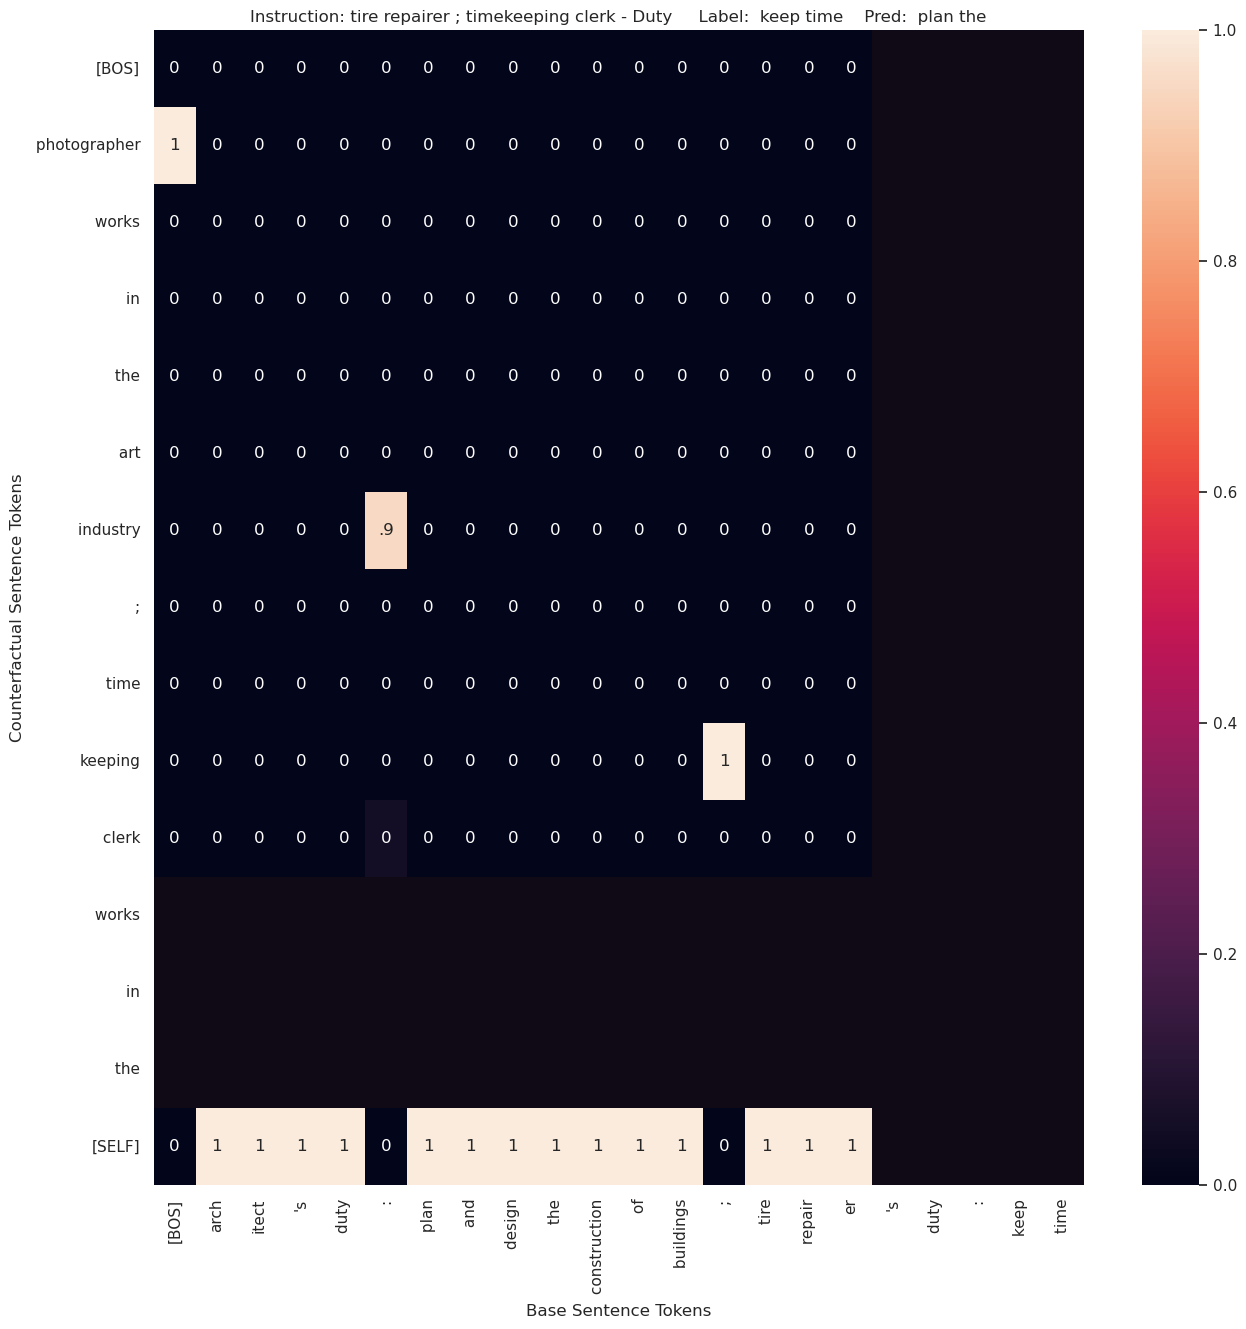

In [7]:
# hypernetwork.interpretor.bidding_threshold = 0.2
import seaborn as sns

fig, ax = hypernetwork.plot_heatmap(
    dataloader, 
    idxs=11, 
    inference_mode=None, 
    annot=True, batch_size=16, 
    indicate_masked_tokens=True,
    digits=1,
)